# Movie Industry: Webscrapping Profitability Numbers

In [206]:
from IPython.core.display import display, HTML

display(HTML('''<script> code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>

<a href="javascript:code_toggle()">see notebook code clicking here</a>.'''))

In [20]:
from IPython.core.display import display, HTML

display(HTML('<img src=http://www.boxofficemojo.com/img/misc/bom_logo1.png height=300 width=400 align= "top" border="1"></img>')) 



In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns 
import datetime as datetime

### Scrapping the web for Movies Info:

The following analysis seeks to shed some light on the opaque world of movie producers and distributors. Only movie production businesses are considered thus leaving aside the movie theater industry. There's plenty of movie analysis out there that grasp superifically this exciting industry and the idea is to provide answer to the next questions:

- Is cinema more or less affordable for consumers?
- Are cinema corporates benefitting from above-inflation revenue high-rates? Are there any lessons from the past to learn?
- Is the Opening weekend as important as media highlights? Is it helpful to predict a studio/company peformance?
- What Particular parent company has raised over the last years? What company has been de-rated?
- Any underdog rising to fame over the last years?
- What’s the most profitable studio? Is there an correlation between ROC(Return-on-Capital) and Total Revenues?
- Can we use weekly box office to track earnings momentum and get hints about next quarterly earnings?
- Are box offices numbers properly incorporated in top studios stock prices? 


Python has been used for webscrapping using both Beautiful soup and Scrapy libraries depending on the website targeted. Data analysis has been conducted using both R and Python.

Python is the favourite choice for webscrapping because there a lot of existing libraries a user can build and it's a language that allows to maniupulate strings very easily. In addition, other data science languages like R have also available packages to carry out webscrapping but the fact that R is an interpreted language  - for which most of its implementations execute instructions directly, without previously compiling a program into machine-language instructions - makes it less apt for webscrapping purposes than a compiled language like Python.

The information has been scrapped from multiple websites in order to attain the most comprehensive set of data to extract well-informed and complete details:

- **Federal Reserve Economic Data (FRED)(https://fred.stlouisfed.org/)** is a database maintained by the Research division of the Federal Reserve Bank of St. Louis that has more than 421,000 economic time series from 81 sources.
- **Box Office Mojo (http://www.boxofficemojo.com)** is the leading online box-office reporting service. Box Office Mojo is owned and operated by IMDb (www.imdb.com).
- **The-numbers.com (http://http://www.the-numbers.com)** operated by Nash Information Services, LLC; a provider of movie industry data and research services to major financial institutions, media companies, investors, data analysis companies and production companies. This website as been used as backup to fill budget data not available in Box Office Mojo.

### The Movie Industry: A Brief Intro

The global film industry is a 38 bn USD market as of 2016 with future global box office revenue expected to reach 50 bn USD by 2020 tantamoun to 7.1% annualised growth. China and India are the two largest markets in terms of tickets sold per year; while the United States is on the third position. Nevertheless, the US ranks first with more than half of the market when considering total revenue in US dollars. There are four particular trends impacting the industry:

**1) China and India overtaking the US:** China is expected to become the world's biggest film market in 2017 with growth figures surpasing 50% on a YoY basis. Major film studios are forming new partnerships with Chinese companies to gain better access to the world's fastest-growing film market with hits like Furious 7 and Jurassic World being the result of co-production efforts.

**2) Movie franchises:** Film universes have become pivotal in the long term strategy of top studios such as Disney or Time Warner. The expansion of comic-book universes (e.g. Marvel), animated films (e.g. Frozen) and old-school franchises (e.g. Star Wars) with 5-year release plans including spin-offs and tie-ins has become essential to sustain top studio theatrical earnings.

**3) Premium formats:** The number of big budget productions have increased due to Chinese companies getting more aggressive and signing up co-production deals with western partners. This bigger focus on blockbuster films seek to benefit premium formats (e.g. 3D, IMAX, etc) and boost premium sales mix, particularly in Western Europe and Asian territories.

**4) VOD (Video-On-demand:** A staggering 53 percent of American adults prefer watching movies at home. Surprisingly, home movie on-demand main victim has not been theatrical box office revenues but the US cable-TV industry (cord-cutting effect). Moreover, small-budget pictures are having a harder time standing out at multiplexes but finding ample new avenues through online distribution(HBO, Netflix and Amazon Prime).

### The Challenge: Modeling Industry Economics




#### Chart 1: Movie Theatre Tickets Inflation vs US Consumer Inflation

In [224]:
# webscrapping ticket price info: 
from bs4 import BeautifulSoup
import requests # obtain source code from website
path = requests.get('http://www.boxofficemojo.com/about/adjuster.htm').text
text = BeautifulSoup(path,'html.parser') # html parser is the default one
year = text.find_all('font', {'face': "Verdana"}) # deliver each font tag with key=font and value='Verdana'
t_info = [s.string.encode('utf-8', 'ignore') for s in year][4:] # let's leave 2016 info out

In [229]:
# Federal Reserve API data:https://pypi.python.org/pypi/fredapi
# API info:  https://research.stlouisfed.org/docs/api/fred/series_observations.html#Parameters
from fredapi import Fred
fred = Fred(api_key='d9e91c0596589ffecdf9fe0059742a02')
cpi = fred.get_series('CPIAUCSL', observation_start = '01-12-1947',observation_end = '01-01-2016', frequency='a')[::-1] # rearrange in descending order (newest to oldest)
cpi = list(cpi.values) # transform to iterate and obtain inf:
#calculate US inflation:
us_inf = [ round((cpi[i-1]/cpi[i] -1)*100,2) for i in range(1,len(cpi))] # len(us_inf) = 69 obs

In [230]:
# wrapping up together and creating dataframe:
year=[]
t_p=[]
for t in range(0,len(t_info)-1): 
    if t%2==0:
        year.append(int(t_info[t]))
    else:
        t_p.append(float(t_info[t][1:])) # [1:] deletes initial $ and float(0 cast it into float
        
# calculate ticket inflation:
t_i = [ round((t_p[i-1]/t_p[i] -1)*100,2) for i in range(1,len(t_p))] # but len(t_i) = len(t_p)-1 :

d = {'US_Consumer_Inflation':us_inf,'Ticket_Inflation':t_i[0:69], 'Ticket_Price_USD': t_p[0:69], 'Year': year[0:69]}
import pandas as pd
ticket_p = pd.DataFrame(d) # last input always acts as index
ticket_p = ticket_p[['Year','Ticket_Price_USD','Ticket_Inflation','US_Consumer_Inflation']] # reorder cols
ticket_p.set_index('Year', inplace =True) # set index
ticket_p.index.rename(None,inplace=True) # delete empty row

In [231]:
y = ticket_p[0:40] # last 30 years only

In [232]:
y['Cinema-CPI Inflation Gap'] = pd.Series(y.iloc[:,1]-y.iloc[:,2], index=y.index)
y[0:5]

C:\Users\Carlo\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Ticket_Price_USD,Ticket_Inflation,US_Consumer_Inflation,Cinema-CPI Inflation Gap
2015,8.43,3.18,1.28,1.90
2014,8.17,0.49,0.12,0.37
2013,8.13,2.14,1.61,0.53
2012,7.96,0.38,1.46,-1.08
2011,7.93,0.51,2.07,-1.56


Ticket Inflation seems to be a good leading indicator for US overall consumer inflation. In other words, cinema ticket prices are a good approximation to predict turning points in overall consumer inflation. This makes sense from an economics standpoint since non-staples goods and services consumption, such as films and other leisure activities, are the first to be cutt off the consumer budget when consumer sentiment weakens.   


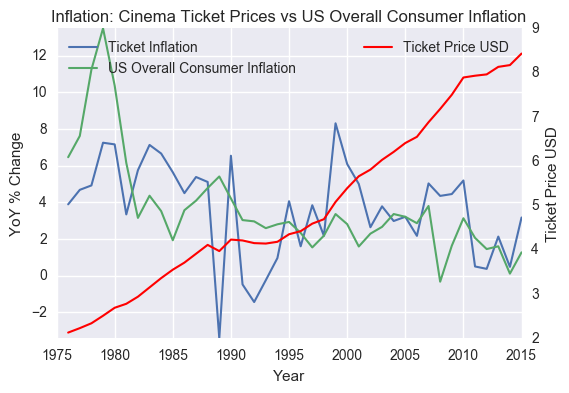

In [233]:
plt.figure(figsize=(7, 4))

fig, ax1 = plt.subplots() # allows to chart two series with different scales

plt.plot(y.iloc[:, 1], lw=1.5, label='Ticket Inflation')
plt.plot(y.iloc[:, 2], lw=1.5, label='US Overall Consumer Inflation')
plt.grid(True)
plt.legend(loc=2) #enter the legend 
plt.axis('tight')
plt.xlabel('Year')
plt.ylabel('YoY % Change')
plt.title('Inflation: Cinema Ticket Prices vs US Overall Consumer Inflation')

ax2 = ax1.twinx() #generates a second axis object
plt.grid(False) # False; otherwise it plots also grids for Ticket Prices USD and is a mess

plt.plot(y.iloc[:,0], 'r', lw=1.5, label='Ticket Price USD')
plt.legend(loc=0) #enter the legend 
plt.ylabel('Ticket Price USD');

Another observation is related to periods when cinema tickets were experiencing negative or positive inflation. Looking at the gap between ticket prices and overall inflation is key and helps to spot 3 key periods:

**1) Oil Crisis(1973-1983):** oil crisis fuelled inflation above 10% while ticket prices only soared approximately 3%. The advent of VTRs (Video Tape Recorders) did not have an immediate effect as not until mid 80s a format winner (VHS).   

**2) VTRs (1988-1994):** VHS turned out to be the clear winner and VTRs manufacturers focus on VHS provoked a sudden cheapening in device prices boosting the videotape renting industry and bringing down cinemat ticket prices.

**3) Premium Formats (2000-2010):** cinemas and movie producers developed new ways of experiencing movies (IMAX, 3D, etc) that allow them to mark up cinema-goers dramatically. People acceptance has worn off since 2000 as deflation materialize and consumers became dissapointed with some low quality 3D releases.   

A multi-period statistical analysis is always useful to unveil visual biases and confirm prior and new trends. When analyzing the whole period since 1975 the main takeaways seems to be that the inflation gap between cinema tickets and overall consumer prices converge as reflected by "Cinema-CPI Inflation Gap" column in slightly negative territory. Of course, there are periods when this gap has been either negative or positive as described above. The most interesting one seems to be the one we are living since 2006 as reflected by the last two tables below: the cinema-CPI inflation GAP has been systematically above 1.7% over the last decade. Despite this spread having narrowed to 1% over the last 3 years, it's remarkable how industry incumbents are able to retain such a bargaining power even during times of crisis. 

The next question to be asked is whether or not this is a sustainable advantage thus making necessary to check bottom up figures per top studio and understand more thoroughly the competitive degree of the movie industry.  

In [701]:
y.describe() #  Total Period since 1947

,Ticket_Price_USD,Ticket_Inflation,US_Consumer_Inflation,Cinema-CPI Inflation Gap
count,40.000000,40.000000,40.000000,40.000000
mean,5.151750,3.598750,3.699750,-0.101000
std,1.929291,2.615405,2.811621,3.199303
min,2.230000,-3.410000,-0.320000,-8.200000
25%,3.860000,2.170000,2.162500,-1.720000
50%,4.505000,3.960000,3.005000,0.650000
75%,6.632500,5.247500,4.130000,2.132500
max,8.650000,8.320000,13.500000,6.130000


In [708]:
print('2006-2016: Inflation Stats')
y[0:10].describe()[1:3]#  2005-2015

2005-2015: Inflation Stats


,Ticket_Price_USD,Ticket_Inflation,US_Consumer_Inflation,Cinema-CPI Inflation Gap
mean,7.872000,2.837000,1.770000,1.06700
std,0.546175,1.915023,1.282697,2.39887


In [709]:
print('2014-2016: Inflation Stats')
y[0:3].describe()[1:3] #  2013-2015

2013-2015: Inflation Stats


,Ticket_Price_USD,Ticket_Inflation,US_Consumer_Inflation,Cinema-CPI Inflation Gap
mean,8.416667,2.093333,1.003333,1.09000
std,0.240278,1.417474,0.782581,2.10031


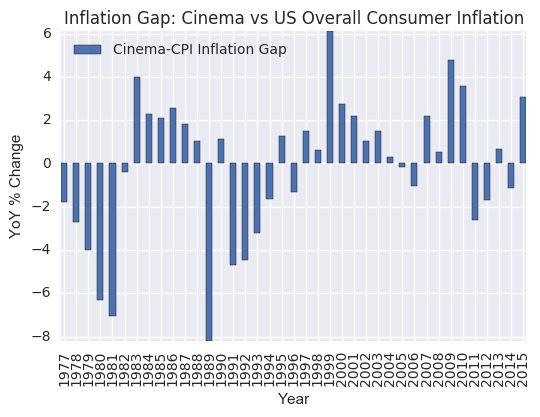

In [438]:
plt.figure(figsize=(7, 4))
y[[3]].plot.bar()
plt.grid(True)
plt.legend(loc=0) #enter the legend 
plt.axis('tight')
plt.xlabel('Year')
plt.ylabel('YoY % Change')
plt.title('Inflation Gap: Cinema vs US Overall Consumer Inflation')
plt.gca().invert_xaxis() ;


### Movie Industry: A Top-Down Competitive Analysis

The plot below points out the remarkable impact a film opening weekend has to determine its failure or success. While during the 90s decade a good opening was significant to predict a movie total success, yet it only represented 15-20% of the total gross revenue. Throughout the last 20 years its importance has sky-rocketed to more than 30% of the total box office. In other words, the first days of a movie release give nowadays more clues than ever about that movie ultimate peformance. Driving this change has to do with several factors: higher budget movies, more intense marketing efforts, the introduction of new premium formats and, last but not least, a lack of screens to sustain a larger than ever before supply of releases forcing studios to bet heavily towards the opening weekend and hope for the best.

Another paradoxical effect is that of the average opening weekend measured in mill USD. Although the market has grown significantly and few new competitors have entered successfully since 2000, the average opening weekend in mill USD has been very volatile. In fact, the median first weekend box office seems to be flattish over the last decade. Once more the top studios new strategy based on movie franchise expansion, blockbuster and premium formats are behind this trend as the next example below the chart explains more in detail.   

##### Movie Opening Weekend as % Total Gross Revenue 

In [714]:
from bs4 import BeautifulSoup
import requests # obtain source code from website
import pandas as pd

ow_p=[]
avg_ow=[]
avg_gross=[]
y_l=[]

start = 1990
end = 2016
year = range(start,end+1)
for y in year:
    pre = 'http://www.boxofficemojo.com/yearly/chart/?yr='
    pos = '&view=releasedate&view2=opening&sort=opengross&order=DESC&p=.htm' 
    path = requests.get(pre+str(y)+pos).text
    text = BeautifulSoup(path,'html.parser') # html parser is the default one
    info = text.find_all('font', {'size': 2}) # deliver each font tag with key=font and value size=2 (chrome dev tool)
    info = info[len(info)-10:len(info)] # we just want the last table data. Order is always the same for any thus:
    ow_p.append(float(info[4].string.encode('utf-8', 'ignore').replace('%',''))) # float. opening weekend as % total gross rev
    avg_ow.append(int(info[3].string.encode('utf-8', 'ignore')[1:].replace(',',''))) # int. average opening weekend per movie in mill USD
    avg_gross.append(int(info[7].string.encode('utf-8', 'ignore')[1:].replace(',',''))) # int. average total gross rev per movie in mill USD
    y_l.append(str(y))

ow = pd.DataFrame({'Avg Opening Week. Mill USD':avg_ow,'Avg Opening. Week as % Tot':ow_p,'Avg Total Gross Mill USD':avg_gross,'Year':y_l})
ow.set_index('Year',inplace=True)
ow.index.rename(None,inplace=True)

(1990, 2017)

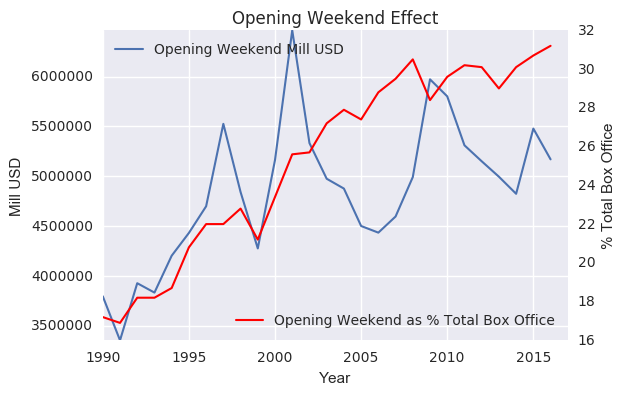

In [722]:
plt.figure(figsize=(7, 4))

fig, ax1 = plt.subplots() # allows to chart two series with different scales

plt.plot(ow.iloc[:, 0], lw=1.5, label='Opening Weekend Mill USD')
plt.grid(True)
plt.legend(loc=2) #enter the legend 
plt.axis('tight')
plt.xlabel('Year')
plt.ylabel('Mill USD')
plt.title('Opening Weekend Effect')

ax2 = ax1.twinx() #generates a second axis object
plt.grid(False) # False; otherwise it plots also grids for Ticket Prices USD and is a mess

plt.plot(ow.iloc[:,1], 'r', lw=1.5, label='Opening Weekend as % Total Box Office')
plt.legend(loc=0) #enter the legend 
plt.ylabel('% Total Box Office')
plt.xlim([1990,2017])

The blockbuster/ movie franchise effect is very significant and explains the effect mentioned earlier. Let's imagine a market in two different points in time: a 5-player industry with fairly the same revenue per player(40 mill USD) and aggregated 200 mill USD size in 2000. Later in 2016, the market has grown to 240 mill USD attracting an additional 2 players. Nonetheless, the market average gross revenue is now lower at 34.3 mill USD compared to the initial 40 mill USD. What has happened? the blockbuster effect enters here: the two biggest players have grown dramatically (Top Studios) yet the remainder players have seen their importance downsized (mid-tier and lower-tier producers). 

In [3]:
Market = pd.DataFrame({'Year':['2000','2000','2000','2000','2000','2016','2016','2016','2016','2016','2016','2016'],
                   'Gross':[40,40,40,40,40,100,75,50,5,5,5,0]})

print 'Market is made out of 5 players in 2000:',[40,40,40,40,40]
print 'Market increases to 7 players in 2016:',[100,75,50,5,5,5,0]
print('')
print('*'*90)
print(Market.groupby('Year').agg(['mean','count','sum']))

Market is made out of 5 players in 2000: [40, 40, 40, 40, 40]
Market increases to 7 players in 2016: [100, 75, 50, 5, 5, 5, 0]

******************************************************************************************
          Gross           
           mean count  sum
Year                      
2000  40.000000     5  200
2016  34.285714     7  240


#### Chart 3: Movie Top Studios: Market Share  Evolution

In [146]:
from bs4 import BeautifulSoup
import requests # obtain source code from website
import pandas as pd

name=[]
mkt=[]
y_l=[]
rank=range(1,21,1) #Top 20

start = 2000 # no data below 2000
end = 2016
year = range(start,end+1)

for y in year:
    pre = 'http://www.boxofficemojo.com/studio/?view=parent&view2=yearly&yr='
    pos = '&p=.htm' 
    path = requests.get(pre+str(y)+pos).text
    text = BeautifulSoup(path,'html.parser') # html parser is the default one
    info = text.find_all('b')[7:47] # top 25 
    data = [x.string.encode('utf-8', 'ignore') for x in info]
    for i in range(0,len(info)):        
        rank
        if i%2==0:
            y_l.append(str(y))
            name.append(data[i])
        else:
            mkt.append(float(data[i].replace('%','')))
df = pd.DataFrame({'Name':name,'Share':mkt,'Year':y_l,'Ranking':rank*(end-(start-1)),'Ranking_':rank*(end-(start-1))})
df.set_index('Ranking',inplace=True)
df.index.rename(None,inplace=True)

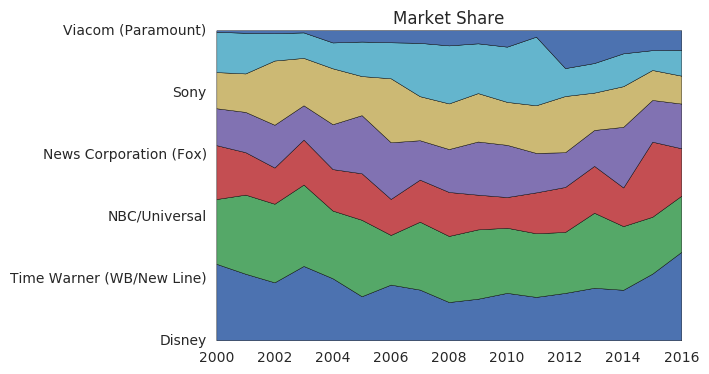

In [572]:
import numpy as np
from matplotlib import pyplot as plt

m_dis = np.array(df.loc[df.Name =='Disney','Share'])
m_twd = np.array(df.loc[df.Name =='Time Warner (WB/New Line)','Share'])
m_com = np.array(df.loc[df.Name =='NBC/Universal','Share'])
m_nwc = np.array(df.loc[df.Name =='News Corporation (Fox)','Share'])
m_son = np.array(df.loc[df.Name =='Sony','Share'])
m_par = np.array(df.loc[df.Name =='Viacom (Paramount)','Share'])
m_lio = np.array(df.loc[df.Name =='Lionsgate','Share'])

y = np.row_stack((m_dis, m_twd, m_com,m_nwc,m_son,m_par, m_lio))
x = np.unique(df.loc[:,'Year'].astype(int))

# Make new array consisting of fractions of column-totals, using .astype(float) to avoid integer division
percent = y /  y.sum(axis=0).astype(float) * 100 

fig = plt.figure()
ax = fig.add_subplot(111)

ax.stackplot(x, percent)
ax.set_title('Market Share')
#ax.set_ylabel('Percent (%)')
ax.margins(0, 0) # Set margins to avoid "whitespace"
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

ax.set_yticklabels(['Disney','Time Warner (WB/New Line)','NBC/Universal','Fox',
                    'Sony','Viacom (Paramount)','Lionsgate'])
plt.show()

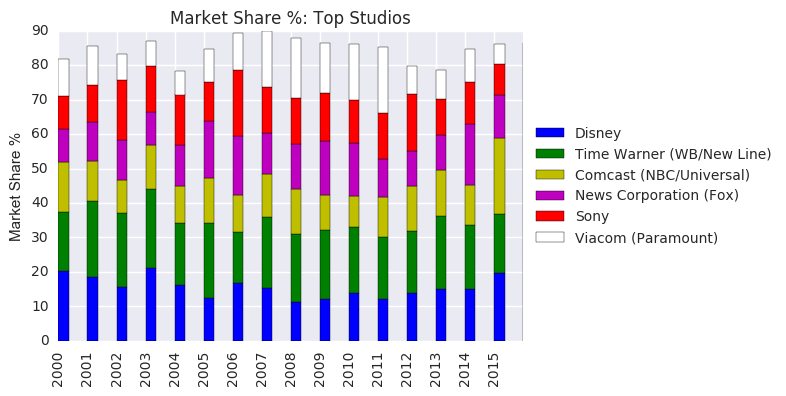

In [618]:
mk_dis = np.array(df.loc[df.Name =='Disney','Share'])
mk_twd = np.array(df.loc[df.Name =='Time Warner (WB/New Line)','Share'])
mk_com = np.array(df.loc[df.Name =='NBC/Universal','Share'])
mk_nwc = np.array(df.loc[df.Name =='News Corporation (Fox)','Share'])
mk_son = np.array(df.loc[df.Name =='Sony','Share'])
mk_par = np.array(df.loc[df.Name =='Viacom (Paramount)','Share'])
mk_lio = np.array(df.loc[df.Name =='Lionsgate (NBC/Universal)','Share'])

x = np.unique(df.loc[:,'Year'].astype(int))        
#width = 0.35

plt.bar(x, mk_dis, width, color='b', label='Disney')
plt.bar(x, mk_twd, width,color='g',label='Time Warner (WB/New Line)',bottom = mk_dis)
plt.bar(x, mk_com, width,color='y',label='Comcast (NBC/Universal)', bottom = mk_dis+mk_twd)
plt.bar(x, mk_nwc, width,color='m',label='Fox', bottom = mk_dis+ mk_twd+ mk_com)
plt.bar(x, mk_son, width,color='r',label='Sony', bottom = mk_dis + mk_twd + mk_com + mk_nwc)
plt.bar(x, mk_par, width,color='w',label='Viacom (Paramount)', bottom = mk_dis + mk_twd + mk_com + mk_nwc + mk_son)

plt.ylabel('Market Share %')
plt.title('Market Share %: Top Studios')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.xlim([min(x),max(x)])
plt.xticks(range(min(x),max(x),1), rotation= 'vertical')
plt.show()

The 4-firm concentration ratio is the measure of the percentage market share in an industry held by the largest firms within that industry. A concentration ratio below 50% is featured by industries with high competition levels, whereas a ratio above 80%  is symptom of Oligopoly or even Oligopoly when the ratio goes well above 95%.

The movie industry has experiencied a 4-firm concentration ratio consistently above 50% since 2000 and even earlier. Although competitive levels surged dramatically for the period 2010-2013, a sharp reversal has happened over the last 3 years as Disney, Time Warner and Comcast have imposed a relentless high-budget blockbuster model difficult to follow by mid-tier and low-tier competitors.  


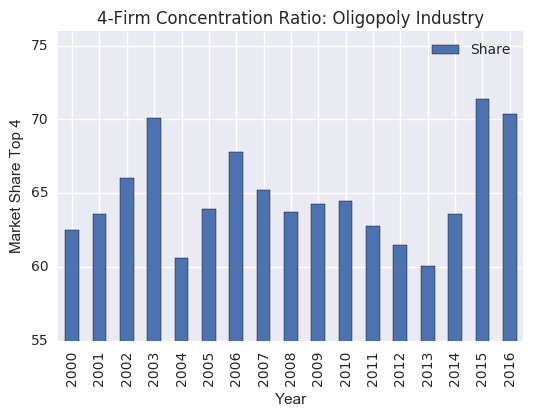

In [634]:
conc = 4
plt.figure(figsize=(12, 4))
conc_ratio_by_year = df.groupby('Year').head(conc).groupby('Year').sum()[[1]]
conc_max = int(conc_ratio_by_year.max()+5)
conc_min = int(conc_ratio_by_year.min()-5)

conc_ratio_by_year.plot.bar()
plt.grid(True)
plt.xlabel('Year')
plt.ylabel('Market Share Top '+ str(conc))
plt.title(str(conc) +'-Firm Concentration Ratio: Oligopoly Industry')
plt.ylim([conc_min,conc_max]);

Another useful to measure an industry-specific competitive level is the Herfindahl-Hirschman index (HHI). This measure is a commonly accepted measure of market concentration and obtained by simply summing the square of the market share of each firm competing in the market.The U.S. DOJ(Department of Justice) uses the HHI for evaluating corporate mergers and acquisitions. 

The U.S. DOJ considers a market with an HHI of less than 1,500 to be a competitive marketplace, an HHI of 1,500 to 2,500 to be a moderately concentrated marketplace, and an HHI of 2,500 or greater to be a highly concentrated marketplace. The chart below provides a very visual confirmation upon our suspicions when checking the 4-firm  concentration ratio: the movie industry has become a moderately concentrated market (HHI above 1,500) in 2016. In fact, this change in the degree of competitiveness is a clear symptom of the industry trends mentioned in the introduction like premium formats and franchises.  

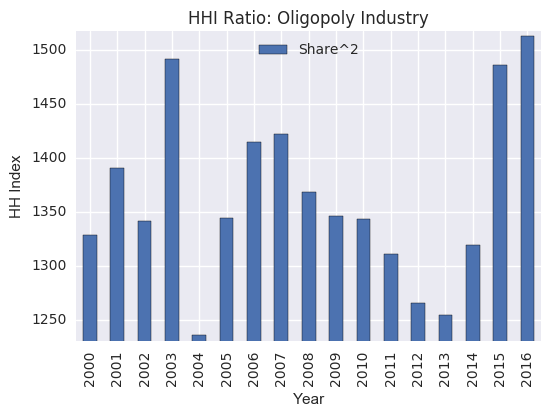

In [641]:
df_HHI =  df
df_HHI['Share^2'] = df_HHI['Share']**2
df_HHI =  df_HHI.groupby('Year').sum()[[2]]

HHI_max = int(df_HHI.max()+5)
HHI_min = int(df_HHI.min()-5)

plt.figure(figsize=(7, 4))

df_HHI.plot.bar(label='HHI Index')
plt.grid(True)
plt.xlabel('Year')
plt.ylabel('HH Index')
plt.title('HHI Ratio: Oligopoly Industry')
plt.ylim([HHI_min,HHI_max]);

Similar conclusions are drawn when checking ranking positions by box office gross revenue figures. Almost all the players in the industry move from occasional number ones to some position around the top 5. Barriers of entry are high, for which reason only one underdog has managed to rise since 2000: Lionsgate. The company has been able to monetize several licenses such as The Twilight Saga or The Hunger Games promoting itself from 14th position in 2000 to 7th in 2016. On the other hand, Viacom-owned Paramount pictures has been the main victim as the studio has not been able to build sustainable cinematic universes like Disney or Time Warner despite its success with some franchises like the Start Trek reboot. 

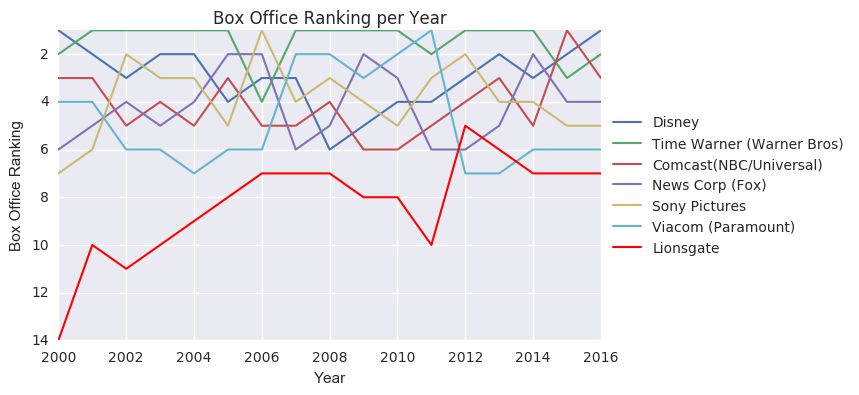

In [477]:
# First get ranking/ Year and set 'Year' as new index for each major Top Studio:
rank_dis = df.loc[df.Name =='Disney',['Year','Ranking_']].set_index('Year')
rank_twd = df.loc[df.Name =='Time Warner (WB/New Line)',['Year','Ranking_']].set_index('Year')
rank_com = df.loc[df.Name =='NBC/Universal',['Year','Ranking_']].set_index('Year')
rank_nwc = df.loc[df.Name =='News Corporation (Fox)',['Year','Ranking_']].set_index('Year')
rank_son = df.loc[df.Name =='Sony',['Year','Ranking_']].set_index('Year')
rank_par = df.loc[df.Name =='Viacom (Paramount)',['Year','Ranking_']].set_index('Year')
rank_lio = df.loc[df.Name =='Lionsgate',['Year','Ranking_']].set_index('Year')
# Second, let's plot them:
plt.figure(figsize=(7, 4))

plt.plot(rank_dis, lw=1.5, label='Disney')
plt.plot(rank_twd, lw=1.5, label='Time Warner (Warner Bros)')
plt.plot(rank_com, lw=1.5, label='Comcast(NBC/Universal)')
plt.plot(rank_nwc, lw=1.5, label='Fox)')
plt.plot(rank_son, lw=1.5, label='Sony Pictures')
plt.plot(rank_par, lw=1.5, label='Viacom (Paramount)')
plt.plot(rank_lio, 'r', lw=1.5, label='Lionsgate')
#plt.plot(rank_lio, 'ro', label='Lionsgate')

plt.grid(True)
plt.axis('tight')
plt.xlabel('Year')
plt.ylabel('Box Office Ranking')
plt.title('Box Office Ranking per Year')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.gca().invert_yaxis() 
    
# useful links:
# http://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
# http://stackoverflow.com/questions/2051744/reverse-y-axis-in-pyplot

### Movie Industry: A Bottom-Up Profitability Analysis

Top studios' parent companies considered in this analysis for the period 2010-2016 have different degrees of dependency with regards their movie business cash flow generation. The plot underneath highlights information extracted from each company's SEC 10-k annual report and how some companies have a radically different revenue segmentation than others with regards movie-related inflows: small and less diversified players such as Lionsgate or The Weinsten Co - more than 80% revenues linked to the film industry - are to be more sensitive to box office numbers releases than other big conglomerates like Sony whose market share in the movie industry is remarkable but only accounting for 5% of the total revenues. 

There's one matter worth considering as it could misleading to think that big guns like Time Warner, Disney or Comcast (Universal) only obtain profits from the theatrical release. The most important strength in these giants is to understand how to leverage their intellectual property to turn content originated in film format to other formats. For instance, Disney is able to monetize its Marvel Comics Universe and Star Wars Universe via both cinema tickets and, most importantly, lending these intangible assets rights to toy manufacturers like Hasbro and video-game developers like Capcom or Activision. Hence, the movie "echo" effect expands across all the other segments of the income statement. This is a  very difficult effect to quantify.


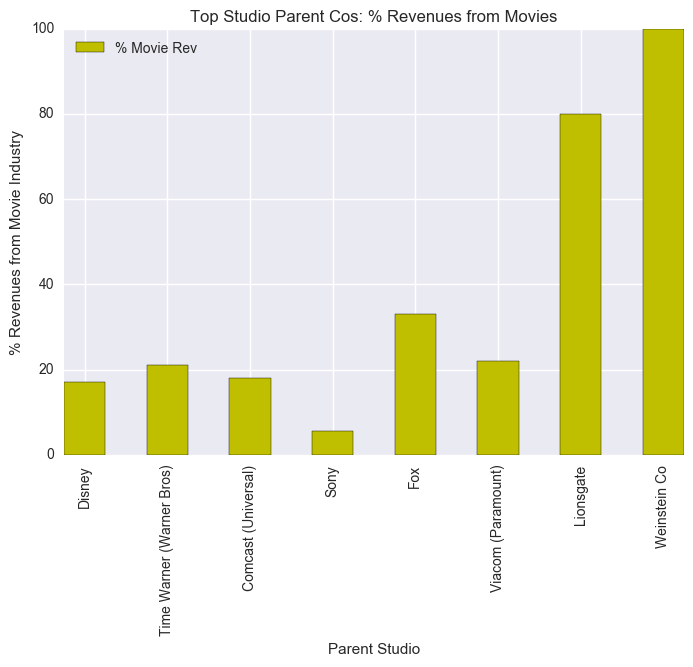

In [39]:
# % Rev info extracted from parent companys' 10-K Reports
comp_dict = {'Studio Parent':['Disney', 'Time Warner (Warner Bros)','Comcast (Universal)','Sony','Fox','Viacom (Paramount)','Lionsgate','Weinstein Co'],
             '% Movie Rev':[17, 21, 18, 5.5, 33, 22, 80, 100]}
comp_df = pd.DataFrame(comp_dict).set_index('Studio Parent')
plt.figure(figsize=(7, 4))
comp_df.plot.bar(color='y')
plt.grid(True)
plt.legend(loc=0) #enter the legend 
plt.axis('tight')
plt.xlabel('Parent Studio')
plt.ylabel('% Revenues from Movie Industry')
plt.title('Top Studio Parent Cos: % Revenues from Movies')

When scrapping movies information, our main objective is to obtain more transparency about the theatrical movie business within top studios. Box office figures are easy to obtain and aggregate; however, the real challenge is to allocate those to their parent companies (multiples studios can be owned by a single company), understand what's the slice of gross revenue that goes to the distributor and the part that stays at cinema theaters and, most importantly, come out with an approximated gross and net profit number per movie that intends to roughly shed some more light on the real profitability beyond the sometimes misleading headline box office numbers. 


In [2]:
data = pd.read_csv('industry.csv')
data.set_index('Year',inplace=True)
data.index.rename(None,inplace=True)
print(data.describe())

           Opening          ROC     Domestic       Budget       Mkting  \
count  1146.000000  1146.000000  1146.000000  1146.000000  1146.000000   
mean     19.653621    16.197528    62.625976    59.554712    34.137696   
std      28.980094   152.324326    89.630524    56.187329    25.482367   
min     -28.350000  -100.000000     0.005000     0.000000     2.700000   
25%       1.398605   -76.425000     6.367000    19.000000    19.000000   
50%      11.210570   -24.750000    33.663000    40.000000    28.000000   
75%      24.752521    48.675000    79.096750    84.000000    41.000000   
max     250.967640  1201.800000   936.662000   315.000000   130.000000   

         ParentRev      NProfit      GProfit        Total     Overseas  
count  1146.000000  1146.000000  1146.000000  1146.000000  1146.000000  
mean     99.424291     6.097939    40.235635   155.475668    93.025469  
std     160.552420   128.011730   133.871619   247.319260   166.654059  
min       0.003000  -339.230000  -214.230

An open debate in the industry is whether or not a big production budget and aggressive marketing campaigns guarantee box office success. When regressing the overall box office revenue figures against budget and marketing expenses, the regression model is outcome is rather spurious and statistically non-significant with a low coefficient of determination and significance statistics confirming that the model is not able to capture a meaningful relationship.  

In [3]:
import pandas as pd
import statsmodels.formula.api as sm
x1 = list(data.loc[:,'Budget'])
x2 = list(data.loc[:,'Mkting'])
y = list(data.loc[:,'Total'])

dfr = pd.DataFrame({'x1':x1,'x2':x2,'y':y})

result = sm.ols(formula="y ~ x1 + x2", data=dfr).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     377.6
Date:                Mon, 13 Feb 2017   Prob (F-statistic):          1.24e-126
Time:                        19:41:08   Log-Likelihood:                -7650.2
No. Observations:                1146   AIC:                         1.531e+04
Df Residuals:                    1143   BIC:                         1.532e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -8.1685     10.398     -0.786      0.4

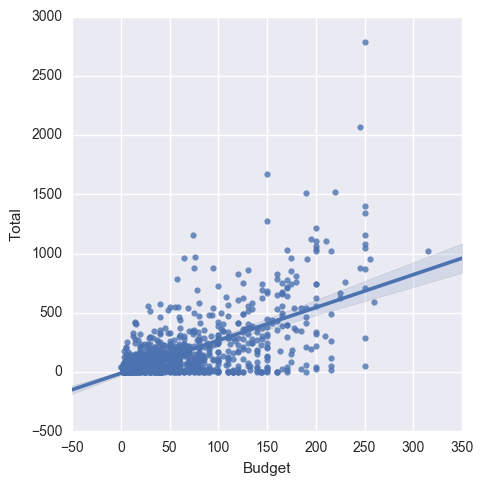

In [4]:
sns.lmplot("Budget",  "Total", data)

There seems to be a missing variable in the linear regression model shown above. Genre could play a much bigger role than expected in a movie success in terms of gross box office numbers and profitability. The table below shows a top 5 best and worst boc office genres.

In [235]:
stats_by_genre = data.groupby('Genre').mean()
print('Top 5 by Genre')
print(stats_by_genre.sort_index(by=['Total'], ascending=[False]).loc[:,'Total'][0:5])
print(90*'#')
print('Worst 5 by Genre')
print(stats_by_genre.sort_index(by=['Total'], ascending=[True]).loc[:,'Total'][0:5])


Top 5 by Genre
Genre
Sci-Fi Fantasy        737.339000
Sci-Fi Adventure      714.053667
Period Adventure      683.692000
Action / Adventure    501.780320
Fantasy               461.535783
Name: Total, dtype: float64
##########################################################################################
Worst 5 by Genre
Genre
Crime Comedy         1.508000
Foreign / Horror     6.091000
Period Comedy        9.504000
Documentary         10.307450
Crime               18.214333
Name: Total, dtype: float64


C:\Users\Carlo\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  app.launch_new_instance()
C:\Users\Carlo\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


Genre is probably a good way to add an additional explanatory variable using a dummy format: the new variable is equal to 1 when a movie genre belong to those genres ranking above the average in terms of box office success and 0 otherwise. Another factor that logically plays an important role is seasonality thus a second dummy variable with value 1 when their release date occurs during traditionally low season months like September, January, February and March or 0 otherwise. 


(array([ 473.,  287.,  134.,   94.,   63.,   44.,   33.,   15.,    2.,    1.]),
 array([   0. ,   31.5,   63. ,   94.5,  126. ,  157.5,  189. ,  220.5,
         252. ,  283.5,  315. ]),
 <a list of 10 Patch objects>)

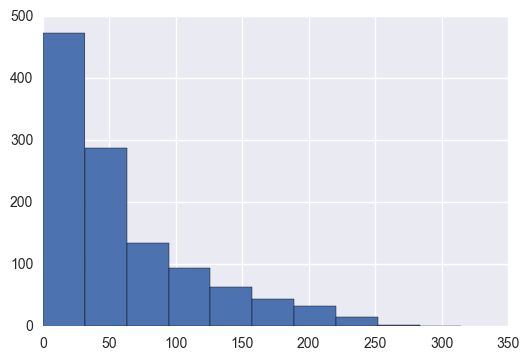

In [236]:
new_y = (data.loc[:,'Budget']**0.2 - 1)/0.2
plt.hist(data.loc[:,'Budget'])

In [191]:
#Creating dummy var1: genre  
tot_by_genre = data.groupby('Genre').mean().loc[:,['Total']]
d_t  = tot_by_genre.mean() # 94 mill USD

best_genre = tot_by_genre.loc[tot_by_genre.Total >= float(d_t),:] # 19 genres left from 60 
data['dummy_genre'] = [1 if i in best_genre.index else 0 for i in data.Genre]

#Creating dummy var2: spring_summer  
data['Month'] = [i[len(i)-7:len(i)-5] for i in data.Date]
data['dummy_season'] = [1 if i in ['09','01','02','03'] else 0 for i in data.Month]
# Running the regression:
import pandas as pd
import statsmodels.formula.api as sm
x1 = list(data.loc[:,'Budget'])
x2 = list(np.log(data.loc[:,'Mkting']))
d1 = list(data.loc[:,'dummy_genre'])
d2 = list(data.loc[:,'dummy_season'])
y = list(data.loc[:,'Total'])

dfr = pd.DataFrame({'x1':x1,'x2':x2,'d1':d1,'d2':d2, 'y':y})

result = sm.ols(formula="y ~ x1 + x2 + d1 + d2", data=dfr).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     261.0
Date:                Mon, 13 Feb 2017   Prob (F-statistic):          2.80e-159
Time:                        22:01:41   Log-Likelihood:                -7568.5
No. Observations:                1146   AIC:                         1.515e+04
Df Residuals:                    1141   BIC:                         1.517e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    122.3071     30.629      3.993      0.0

In [245]:
set(data['Parent'])

{'Comcast (Universal)',
 'Disney',
 'Fox Group',
 'Lionsgate',
 'Sony',
 'Time Warner (Warner Bros)',
 'Viacom (Paramount)',
 'Weinstein Co'}

In [249]:
#Creating dummy var1: genre  
tot_by_genre = data.groupby('Genre').mean().loc[:,['Total']]
d_t  = tot_by_genre.mean() # 94 mill USD

best_genre = tot_by_genre.loc[tot_by_genre.Total >= float(d_t),:] # 19 genres left from 60 
data['dummy_genre'] = [1 if i in best_genre.index else 0 for i in data.Genre]

#Creating dummy var2: spring_summer  
data['Month'] = [i[len(i)-7:len(i)-5] for i in data.Date]
data['dummy_season'] = [1 if i in ['09','01','02','03'] else 0 for i in data.Month]
# Running the regression:
import pandas as pd
import statsmodels.formula.api as sm
x1 = list(data.loc[data.Parent=='Weinstein Co','Budget'])
x2 = list(np.log(data.loc[data.Parent=='Weinstein Co','Mkting']))
d1 = list(data.loc[data.Parent=='Weinstein Co','dummy_genre'])
d2 = list(data.loc[data.Parent=='Weinstein Co','dummy_season'])
y = list(data.loc[data.Parent=='Weinstein Co','Total'])

dfr = pd.DataFrame({'x1':x1,'x2':x2,'d1':d1,'d2':d2, 'y':y})

result = sm.ols(formula="y ~ x1 + x2 + d1 + d2", data=dfr).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     3.540
Date:                Sat, 18 Feb 2017   Prob (F-statistic):             0.0103
Time:                        21:14:55   Log-Likelihood:                -497.32
No. Observations:                  85   AIC:                             1005.
Df Residuals:                      80   BIC:                             1017.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     54.8354     54.139      1.013      0.3

The economics of each studio are different with some finding more economies of scale and scope in particular areas that may make them excel in extracting value added from their production and marketing budgets. For this reason, the same regression equation is run for every parent company in our sample. Nevertheless, the results are not very encouraging either as the plot below showcases: the adjusted coefficients of determination are well below the minimum required 0.8 threshold. In other words, there's something missing in the model in order to build a relationship between box office numbers and the economic resources allocated.

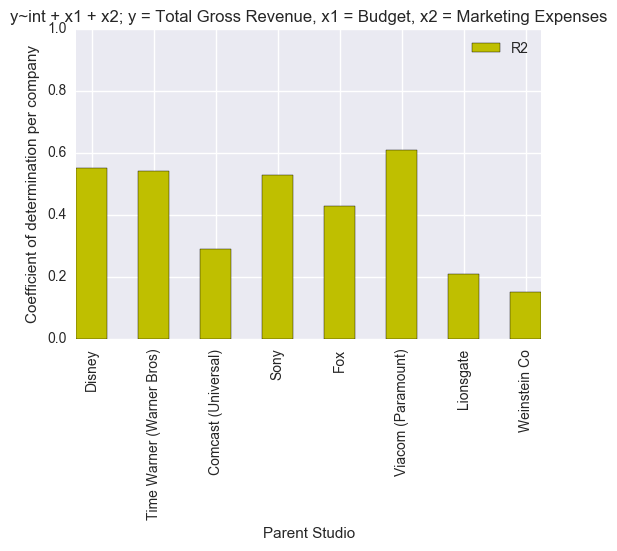

In [250]:
# Y ~ intercept + X1 + X2 => R2 per company
R2_dict = {'Studio Parent':['Disney', 'Time Warner (Warner Bros)','Comcast (Universal)','Sony','Fox','Viacom (Paramount)','Lionsgate','Weinstein Co'],
             'R2':[0.55, 0.54, 0.29, 0.53, 0.43, 0.61, 0.21, 0.15 ]}
R2_df = pd.DataFrame(R2_dict).set_index('Studio Parent')
plt.figure(figsize=(7, 4))
R2_df.plot.bar(color='y')
plt.grid(True)
plt.legend(loc=0) #enter the legend 
plt.axis('tight')
plt.xlabel('Parent Studio')
plt.ylim([0,1])
plt.title('y~int + x1 + x2; y = Total Gross Revenue, x1 = Budget, x2 = Marketing Expenses')
plt.ylabel('Coefficient of determination per company')

The media buzz is always emphasizing box office figures as the leading indicator of sucess for the movie industry. The boxplot below shows a substantial differences when comparing the average movie produced by big guns such as Disney or Warner Bros in comparison to smaller studios such as Lionsgate or Weinstein Co. 

C:\Users\Carlo\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  from ipykernel import kernelapp as app


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

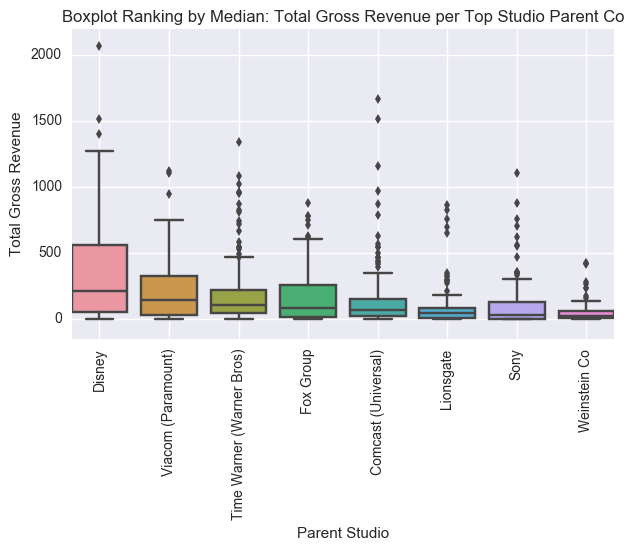

In [312]:
plt.figure(figsize=(7, 4))
index = data.groupby('Parent').median().sort_index(by=['Total'], ascending = [False])['Total'].index
sns.boxplot(x='Parent', y='Total', data=data, order = index)
plt.grid(True)
plt.legend(loc=0) #enter the legend 
plt.axis('tight')
plt.xlabel('Parent Studio')
plt.ylim([-150,2200])
plt.title('Boxplot Ranking by Median: Total Gross Revenue per Top Studio Parent Co')
plt.ylabel('Total Gross Revenue')
plt.xticks(rotation='vertical')

#### 2010-2016 Aggregated ROC (Return on Budget+Marketing Expenses) by Parent Company

That said, the media simplifies the debat by uniquely starting at top-line figures while ignoring dramatically important factors such as the production budget, marketing and promotion costs or the ticket rebate negotiated with theatre companies. Regrettably most of this figures are not provided by the studios or theaters thus the profitability analysis conducted here makes well-informed assumptions for these items for the period 2010-2016:

- *Production Budget:* official figures are considered or estimates from scrapping websites such as Box Office Mojo, The-numbers.com and IMDb.
 
- *Marketing Expenses:* research shows that over the last years productions with budgets below 5 Mill USD spend in marketing and promotion something close to 150% of the production budget. This percentage is 100% for productions with budgets above 5 mill USD but below 40 mull USD. Last but not least, films with larger budgets usually spend an amount close to half their production budget.
 
- *Theatre tickets rebate:* Studios normally arrange a 55-65% rebate with theatres. On a major blockbuster the studio can take 65% of the total gross throughout the run. On smaller movies, the scale starts high and goes down as the film ages. Our estimates are 65% for productions above 40 mill USD budget, 60% for movies above 5 mill USD and 55% for small productions.

The chart below displays annualised return on capital (ROC) - calculated as net profit per movie divided by marketing costs and production budget - for the studios parent companies for the period 2010-2016. The chart is simply taking into account up all inflows and outflows per year for each parent company and calculating an annualised ROC number that provides a good starting point to study the profitability of the filming segments of the firms in our sample. Apparently there seems to be a correlation between top box office success and overall profitability when comparing our previous chart and the one below:

 

C:\Users\Carlo\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


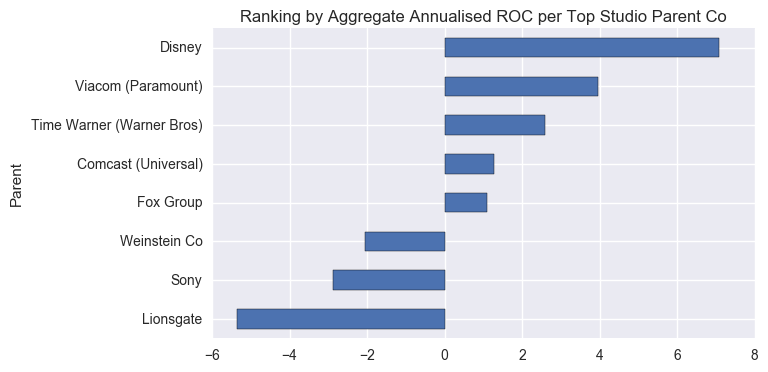

In [378]:
mov_ag = data.groupby('Parent').sum().loc[:,['ParentRev','Budget','Mkting']]
mov_ag['Parent']  = mov_ag.index
mov_ag['Cum ROC'] = (mov_ag['ParentRev']/(mov_ag['Budget']+mov_ag['Mkting']) -1)*100
mov_ag['Annual ROC'] = mov_ag['Cum ROC']/7
ag_df = mov_ag.sort_index(by=['Annual ROC'],ascending=[False])

plt.figure(figsize=(7, 4))
ag_df['Annual ROC'].plot.barh()
plt.title('Ranking by Aggregate Annualised ROC per Top Studio Parent Co')
plt.gca().invert_yaxis() 

 #### 2010-2016 ROC per movie by Parent Company

Aggregate figures however could be masking the truth as a studio might have been lucky with one title whose success has more than offset the mediocrity of the rest of its pipeline. To ascertain and double-check that aggregate figures don't hide any nasty surprise, a more thorough analysis has been conducted averaging ROC per movie for each one of the studios in the sample. 

The outcome when reviewing the boxplot below is fascinating as it can be confirmed that the distribution of ROC seems to be having quite a skewed shape to the right (positive values) and a strong kurtosis due to the blockbuster effect. The boxplot underneath confirms that the aggregate profitability for studios like Fox, Comcast (Universal) or Lionsgate is heaviliy dependent on launching blockbusters to save the season since the median profitability for these studios is in red numbers.  

In [379]:
stats_by_parent = data.groupby('Parent').agg(['mean','std','median','max','min'])
stats_by_parent.shape #8 x 50
ROC_stats = stats_by_parent.iloc[:,5:10].loc[:,'ROC'].reset_index('Parent')
ROC_stats

,Parent,mean,std,median,max,min
0,Comcast (Universal),28.144016,172.882282,-28.80,1320.7,-100.0
1,Disney,49.724444,123.176425,27.25,666.9,-99.5
2,Fox Group,22.456346,174.924608,-17.30,1234.6,-99.9
3,Lionsgate,0.491802,161.370477,-49.70,1188.0,-100.0
4,Sony,5.194394,291.202467,-47.20,4153.9,-100.0
5,Time Warner (Warner Bros),45.181834,197.387807,-11.30,1085.6,-95.9
6,Viacom (Paramount),68.531248,252.079666,10.20,1473.9,-99.2
7,Weinstein Co,-1.210547,153.163346,-51.80,753.2,-100.0


C:\Users\Carlo\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  from ipykernel import kernelapp as app


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

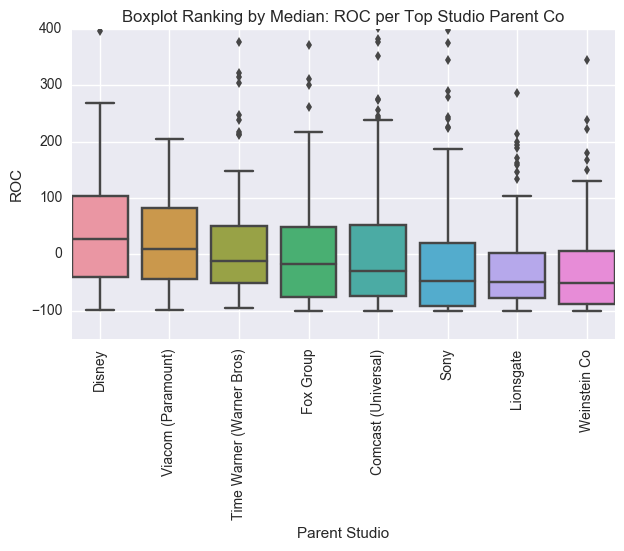

In [309]:
plt.figure(figsize=(7, 4))
index = data.groupby('Parent').median().sort_index(by=['ROC'], ascending = [False])['ROC'].index
sns.boxplot(x='Parent', y='ROC', data=data, order = index)
plt.grid(True)
plt.legend(loc=0) #enter the legend 
plt.axis('tight')
plt.xlabel('Parent Studio')
plt.ylim([-150,400])
plt.title('Boxplot Ranking by Median: ROC per Top Studio Parent Co')
plt.ylabel('ROC')
plt.xticks(rotation='vertical')



## Mojo Index: Tracking Box Office Momentum

Another idea worth studying is the creation of momentum indices using weekly box office information. The objective is to obtain interim signals between quarterly reports that could complement the earnings momentums factors conventionally known and used by investors.

In [3]:
from pandas_datareader import data as web
from datetime import  datetime
symbols = ['^GSPC', 'DIS', 'TWX', 'FOX', 'SNE', 'CMCSA','VIAB','LGF.A']
# Media stocks download
stocks = {i:web.DataReader(i,'yahoo',start = datetime(2009, 12, 31), end = datetime(2016, 12, 31)) for i in symbols}
stocks.keys() # dict of dfs

['SNE', 'VIAB', 'FOX', 'LGF.A', '^GSPC', 'TWX', 'CMCSA', 'DIS']

In [4]:
ff_daily_df.head()

NameError: name 'ff_daily_df' is not defined

In [84]:
# choosing stock and benchmark: tidying up as well
stock=pd.merge(pd.DataFrame(stocks['DIS']['Adj Close']),pd.DataFrame(stocks['^GSPC']['Adj Close']), 
             how='inner',left_index=True, right_index=True)
stock = stock.rename(columns={'Adj Close_x': 'Stock', 'Adj Close_y': 'Index'})
stock.head()

,Stock,Index
Date,,
2009-12-31,29.333866,1115.099976
2010-01-04,29.170142,1132.989990
2010-01-05,29.097376,1136.520020
2010-01-06,28.942748,1137.140015
2010-01-07,28.951844,1141.689941


In [6]:
set(data['Parent'])

{'Comcast (Universal)',
 'Disney',
 'Fox Group',
 'Lionsgate',
 'Sony',
 'Time Warner (Warner Bros)',
 'Viacom (Paramount)',
 'Weinstein Co'}

In [85]:
#select company
data_ts = data.loc[data.Parent=='Disney',:] #df 
data_ts['Date'] = map(lambda x: x[len(x)-4:len(x)]+'-'+x[3:5]+'-'+ x[0:2], data_ts.loc[:,'Date']) #reformat dates

data_ts = data_ts.set_index('Date')[['Opening','Total','GProfit','NProfit','ROC']].sort_index(ascending=True) 
data_ts.index.to_datetime()
data_ts.head()
# a quicker option was:
# f['DateTime'] = pd.to_datetime(df['date'].astype(str), format='%Y%m%d')

C:\Users\Carlo\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,Opening,Total,GProfit,NProfit,ROC
Date,,,,,
2010-01-29,12.350041,43.043,-142.022,-227.022,-89.0
2010-03-05,116.101023,1025.467,466.554,366.554,122.2
2010-03-26,0.033115,0.085,-4.949,-9.949,-99.5
2010-03-31,16.007426,89.042,33.425,13.425,33.6
2010-04-22,6.058958,82.651,44.591,39.591,395.9


In [86]:
merge_data = pd.merge(stock,data_ts, how='inner',left_index=True, right_index=True)

# Cumulative Indices
merge_data['Opening_Cum'] = merge_data['Opening'].cumsum()
merge_data['Total_Cum'] = merge_data['Total'].cumsum()
merge_data['GProfit_Cum'] = merge_data['GProfit'].cumsum()
merge_data['NProfit_Cum'] = merge_data['NProfit'].cumsum()

merge_data['GMargin'] = 100*merge_data['GProfit_Cum']/merge_data['Total_Cum']
merge_data['NMargin'] = 100*merge_data['NProfit_Cum']/merge_data['Total_Cum']

merge_data['Total_Cum_PCHG'] = np.log(merge_data['Total_Cum'] / merge_data['Total_Cum'].shift(1))
merge_data['GProgit_Cum_PCHG'] = np.log(merge_data['GProfit_Cum'] / merge_data['GProfit_Cum'].shift(1))
merge_data['NProfit_Cum_PCHG'] = np.log(merge_data['NProfit_Cum'] / merge_data['NProfit_Cum'].shift(1))

merge_data['Stock_TR'] = np.log(merge_data['Stock']/merge_data['Stock'].shift(1))
merge_data['Index_TR'] = np.log(merge_data['Index']/merge_data['Index'].shift(1))
merge_data['Stock-Index_TR'] = merge_data['Stock_TR']-merge_data['Index_TR']
merge_data['Stock_TR_Cum'] = 100*(1+merge_data['Stock_TR']).cumprod()
merge_data['Index_TR_Cum'] = 100*(1+merge_data['Index_TR']).cumprod()
merge_data['Stock-Index_TR_Cum'] = 100*(1+merge_data['Stock-Index_TR']).cumprod()

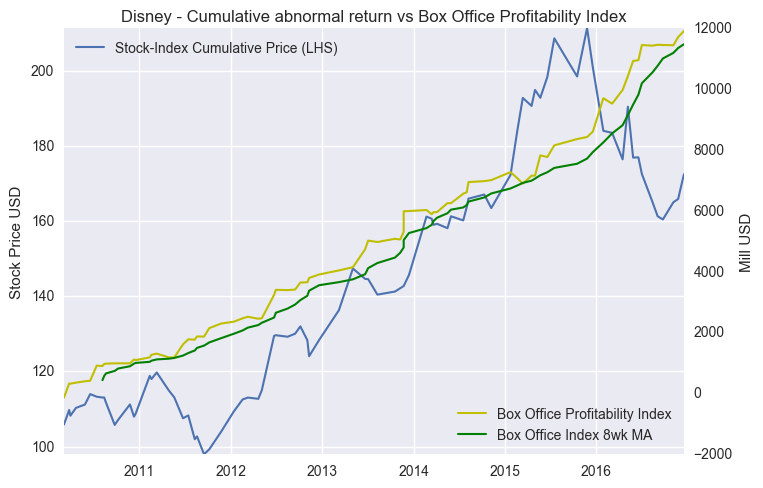

In [88]:
plt.figure(figsize=(7, 4))

fig, ax1 = plt.subplots() # allows to chart two series with different scales

plt.plot(merge_data.loc[:, 'Stock-Index_TR_Cum'], lw=1.5, label='Stock-Index Cumulative Price (LHS)')
plt.grid(True)
plt.legend(loc=2) #enter the legend 
plt.axis('tight')
#plt.xlabel('Year')
plt.ylabel('Stock Price USD')
plt.title('Disney - Cumulative abnormal return vs Box Office Profitability Index')
ax2 = ax1.twinx() #generates a second axis object
plt.grid(False) # False; otherwise it plots also grids for Ticket Prices USD and is a mess
plt.plot(merge_data.loc[:,'GProfit_Cum'].shift(), 'y', lw=1.5, label='Box Office Profitability Index')
plt.plot(merge_data.loc[:,'GProfit_Cum'].shift().rolling(window=8).mean(), 'g', lw=1.5, label='Box Office Index 8wk MA')


plt.legend(loc=4) #enter the legend 
plt.ylabel('Mill USD')

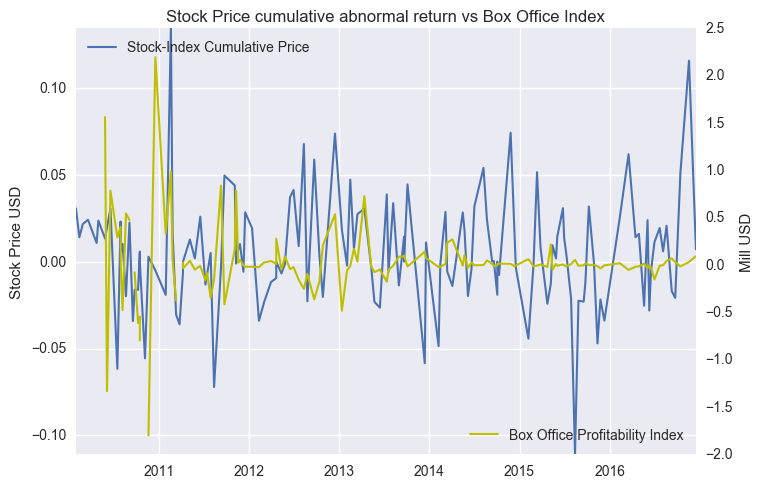

In [53]:
plt.figure(figsize=(7, 4))

fig, ax1 = plt.subplots() # allows to chart two series with different scales

plt.plot(merge_data.loc[:, 'Stock-Index_TR'], lw=1.5, label='Stock-Index Cumulative Price')
plt.grid(True)
plt.legend(loc=2) #enter the legend 
plt.axis('tight')
#plt.xlabel('Year')
plt.ylabel('Stock Price USD')
plt.title('Stock Price cumulative abnormal return vs Box Office Index')
ax2 = ax1.twinx() #generates a second axis object
plt.grid(False) # False; otherwise it plots also grids for Ticket Prices USD and is a mess
plt.plot(merge_data.loc[:,'NProfit_Cum_PCHG'].shift(6), 'y', lw=1.5, label='Box Office Profitability Index')
plt.legend(loc=4) #enter the legend 
plt.ylabel('Mill USD')

In [67]:
# Fama-French Download: create prices from downloaded returns
ff_daily = web.DataReader("F-F_Research_Data_Factors_daily", "famafrench",start = datetime(2009, 11, 30), end = datetime(2016, 12, 31))
ff_daily_df = ff_daily.values()[0]
ff_daily_df
ff_daily_df['Mkt'] = ff_daily_df['Mkt-RF'] + ff_daily_df['RF'] 
ff_daily_df.index.rename(None,'ignore')

ff_daily_df['Mkt-RF_Cum'] = 100*(1 + ff_daily_df['Mkt-RF']/100).cumprod()
ff_daily_df['SMB_Cum'] = 100*(1 + ff_daily_df['SMB']/100).cumprod()
ff_daily_df['HML_Cum'] = 100*(1 + ff_daily_df['HML']/100).cumprod()
ff_daily_df['Mkt_Cum'] = 100*(1 + ff_daily_df['Mkt']/100).cumprod()
ff_daily_df['RF_Cum'] = 100*(1 + ff_daily_df['RF']/100).cumprod()
ff_daily_df.tail()

,Mkt-RF,SMB,HML,RF,Mkt,Mkt-RF_Cum,SMB_Cum,HML_Cum,Mkt_Cum,RF_Cum
2016-12-23,0.19,0.57,-0.54,0.001,0.191,244.180406,113.390515,105.713811,245.251499,100.438958
2016-12-27,0.27,0.21,0.14,0.001,0.271,244.839693,113.628635,105.861810,245.916131,100.439963
2016-12-28,-0.87,-0.30,0.06,0.001,-0.869,242.709588,113.287749,105.925327,243.779119,100.440967
2016-12-29,-0.04,0.13,-0.30,0.001,-0.039,242.612504,113.435023,105.607551,243.684046,100.441972
2016-12-30,-0.52,-0.13,0.18,0.001,-0.519,241.350919,113.287557,105.797645,242.419325,100.442976


In [68]:
ff_merge_df = pd.merge(merge_data,ff_daily_df.iloc[:,5:10], how='inner', left_index=True, right_index=True)
# create return for ff factors for each specific data range:
ff_merge_df['Mkt-RF_TR'] = np.log(ff_merge_df['Mkt-RF_Cum']/ff_merge_df['Mkt-RF_Cum'].shift(1))
ff_merge_df['SMB_TR'] = np.log(ff_merge_df['SMB_Cum']/ff_merge_df['SMB_Cum'].shift(1))
ff_merge_df['HML_TR'] = np.log(ff_merge_df['HML_Cum']/ff_merge_df['HML_Cum'].shift(1))
ff_merge_df['Mkt_TR'] = np.log(ff_merge_df['Mkt_Cum']/ff_merge_df['Mkt_Cum'].shift(1))
ff_merge_df['RF_TR'] = np.log(ff_merge_df['RF_Cum']/ff_merge_df['RF_Cum'].shift(1))
ff_merge_df['Stock_alpha'] = ff_merge_df['Stock_TR']-ff_merge_df['Mkt_TR']-ff_merge_df['SMB_TR']-ff_merge_df['HML_TR']
ff_merge_df['Stock_alpha_Cum'] = 100*(1 + ff_merge_df['Stock_alpha']).cumprod()

ff_merge_df.columns 

Index([u'Stock', u'Index', u'Opening', u'Total', u'GProfit', u'NProfit',
       u'ROC', u'Opening_Cum', u'Total_Cum', u'GProfit_Cum', u'NProfit_Cum',
       u'GMargin', u'NMargin', u'Total_Cum_PCHG', u'GProgit_Cum_PCHG',
       u'NProfit_Cum_PCHG', u'Stock_TR', u'Index_TR', u'Stock-Index_TR',
       u'Stock_TR_Cum', u'Index_TR_Cum', u'Stock-Index_TR_Cum', u'Mkt-RF_Cum',
       u'SMB_Cum', u'HML_Cum', u'Mkt_Cum', u'RF_Cum', u'Mkt-RF_TR', u'SMB_TR',
       u'HML_TR', u'Mkt_TR', u'RF_TR', u'Stock_alpha', u'Stock_alpha_Cum'],
      dtype='object')

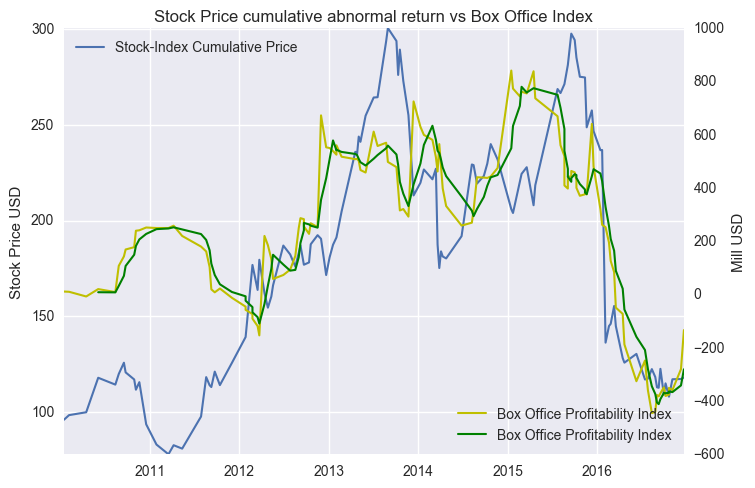

In [69]:
plt.figure(figsize=(7, 4))

fig, ax1 = plt.subplots() # allows to chart two series with different scales

plt.plot(ff_merge_df.loc[:, 'Stock_alpha_Cum'], lw=1.5, label='Stock Alpha Cumulative Price')
plt.grid(True)
plt.legend(loc=2) #enter the legend 
plt.axis('tight')
#plt.xlabel('Year')
plt.ylabel('Stock Price USD')
plt.title('Stock Price cumulative abnormal return vs Box Office Index')
ax2 = ax1.twinx() #generates a second axis object
plt.grid(False) # False; otherwise it plots also grids for Ticket Prices USD and is a mess
plt.plot(ff_merge_df.loc[:,'GProfit_Cum'].shift(), 'y', lw=1.5, label='Box Office Profitability Index')
plt.plot(ff_merge_df.loc[:,'GProfit_Cum'].shift().rolling(window=4).mean(), 'g', lw=1.5, label='Box Office Profitability Index')

#plt.plot(ff_merge_df.loc[:,'NProfit_Cum'], 'r', lw=1.5, label='Box Office Profitability Index').shift(2)
plt.legend(loc=4) #enter the legend 
plt.ylabel('Mill USD')

In [201]:
# Multivariate regression: 
import pandas as pd
import statsmodels.formula.api as sm
MKT = list(ff_merge_df.loc[:,'Mkt_TR'])
SMB = list(ff_merge_df.loc[:,'SMB_TR'])
HML = list(ff_merge_df.loc[:,'HML_TR'])
BOX1 = list(ff_merge_df.loc[:,'NMargin'].shift(1))
BOX2 = list(ff_merge_df.loc[:,'NProfit_Cum_PCHG'].shift(1))
BOX3 = list(ff_merge_df.loc[:,'HML_TR'])
BOX4 = list(ff_merge_df.loc[:,'HML_TR'])

TR = list(ff_merge_df.loc[:,'Stock_TR'])

dfr = pd.DataFrame({'MKT':MKT,'SMB':SMB,'HML':HML,'BOX1':BOX1, 'BOX2':BOX2, 'TR':TR})

result = sm.ols(formula="TR ~ MKT + SMB + HML + BOX1 + BOX2", data=dfr).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                     TR   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     47.26
Date:                Sat, 18 Feb 2017   Prob (F-statistic):           1.46e-27
Time:                        16:42:57   Log-Likelihood:                 282.71
No. Observations:                 135   AIC:                            -553.4
Df Residuals:                     129   BIC:                            -536.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0042      0.004      1.077      0.2